In [106]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), "../"))


import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')


sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

In [107]:
def visualize_feature_importance(model, X_train):
    # barplotに持ち込むためのDFを生成
    df = pd.DataFrame()
    df['feature_name'] = X_train.columns
    df['feature_importance'] = model.feature_importances_

    # 降順のほうが見やすいのでソート
    df.sort_values(by='feature_importance', ascending=False, inplace=True)

    # 重要度0はノイズに思えるので除外している
    df = df[df['feature_importance'] > 0]

    sns.barplot(x='feature_importance',
                y='feature_name',
                data=df)

    plt.xlim(0, 1.0)

# 特徴量のロード(便利だ)

In [123]:
from features.base import BaseFeature, FeatureLoader

features = ['Title', 'FilledAgeFromTitle', 'FamilySize']

X_train, X_test = FeatureLoader(features).load()

train = pd.read_csv('../input_data/train.csv')
test = pd.read_csv('../input_data/test.csv')

train = pd.concat([train, X_train], axis=1)
test = pd.concat([test, X_test], axis=1)

train = train[[
    'Survived', 'Title', 'FilledAge', 'FamilySize',
#    'Pclass', 'Sex', 'Embarked'
]]

test = test[[
    'Title', 'FilledAge', 'FamilySize',
#    'Pclass', 'Sex', 'Embarked'
]]

In [124]:
train.head()

,Survived,Title,FilledAge,FamilySize
0,0,Mr,22.0,2
1,1,Mrs,38.0,2
2,1,Miss,26.0,1
3,1,Mrs,35.0,2
4,0,Mr,35.0,1


# FamilySizeで分析
- 単身者
- 5人以上はもう助からない

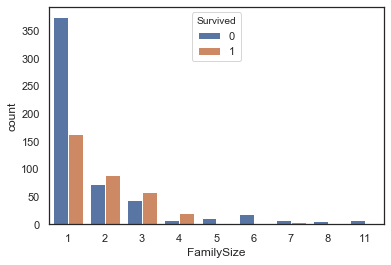

In [125]:
sns.countplot(x='FamilySize',
              hue='Survived',
              data=train)

In [126]:
def to_family_size_category(x):
    if x == 1:
        return 'IsAlone'
    if 2 <= x <= 4:
        return 'IsMedium'
    if 5 < x:
        return 'IsLarge'


train['FamilySizeCategory'] = train['FamilySize'].apply(to_family_size_category)
train.drop('FamilySize', axis=1, inplace=True)

# AgeのCategory化

In [127]:
# Refactor: もっとかっこよくしたいね。よく使う記述だし。
def to_age_category(x: float):
    if x < 10:
        return '0代'
    if 10 <= x < 20:
        return '10代'
    if 20 <= x < 30:
        return '20代'
    if 30 <= x < 40:
        return '30代'
    if 40 <= x < 50:
        return '40代'
    if 50 <= x < 60:
        return '50代'
    if 60 <= x:
        return '60代以上'

train['FilledAgeCategory'] = train['FilledAge'].apply(to_age_category)
train.drop(columns=['FilledAge'], inplace=True)

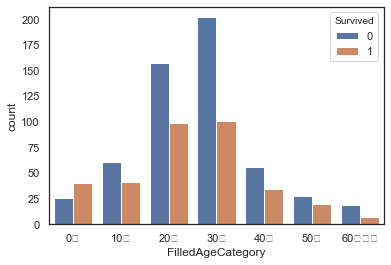

In [128]:
sns.countplot(x='FilledAgeCategory',
              hue='Survived',
              data=train,
              order=['0代', '10代', '20代', '30代', '40代', '50代', '60代以上'])

# 予測モデルつくる

In [129]:
from sklearn.model_selection import train_test_split

X_train = pd.get_dummies(train, drop_first=True).drop(columns=['Survived'])
y_train = train['Survived']

# X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=['Survived']), 
#                                                   train['Survived'],
#                                                   random_state=0)

In [130]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini',
                                    splitter='best',
                                    max_depth=10)

tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [131]:
from sklearn.metrics import roc_auc_score

pred = tree_model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, pred)

0.8513538704076524

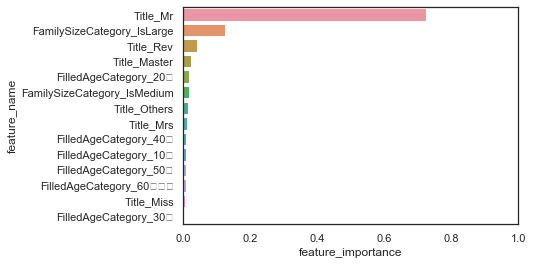

In [132]:
visualize_feature_importance(tree_model, X_train)

# SubmitData

In [133]:
test['FamilySizeCategory'] = test['FamilySize'].apply(to_family_size_category)
test['FilledAgeCategory'] = test['FilledAge'].apply(to_age_category)

test.drop('FamilySize', axis=1, inplace=True)        
test.drop(columns=['FilledAge'], inplace=True)

X_test = pd.get_dummies(test, drop_first=True)

X_test.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Title_Rev,FamilySizeCategory_IsLarge,FamilySizeCategory_IsMedium,FilledAgeCategory_10代,FilledAgeCategory_20代,FilledAgeCategory_30代,FilledAgeCategory_40代,FilledAgeCategory_50代,FilledAgeCategory_60代以上
0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,1,0,1,0,0,0,0


In [136]:
submit_data = pd.read_csv('../input_data/test.csv', usecols=['PassengerId'])
submit_data['Survived'] = tree_model.predict(X_test)

# スコア: 0.73684 -> 0.77033 -> 0.78468
submit_data.to_csv('tree_model_FilledAgeCategory_Title_FamilySize.csv', index=False)